---

# Проект "Продукты питания"

**Описание проекта**  
Стартап, продающий продукты питания, хочет получить аналитику поведения пользователей мобильного приложения.  
Потребуется:  
1. Изучить воронку продаж с исследованием шагов. 
2. Провести A/A/B-эксперименты. Возникло предложение поменять шрифт в приложении. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

## Изучение общей информации

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy
from scipy import stats as st
import math as mth
import seaborn as sns
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [3]:
display(df.sample(10))

,EventName,DeviceIDHash,EventTimestamp,ExpId
15743,MainScreenAppear,4388856809028994842,1564657998,246
90298,MainScreenAppear,4324680624591436809,1564834405,248
28674,OffersScreenAppear,6191431714463699517,1564676285,247
224596,PaymentScreenSuccessful,2768580714092136945,1565175484,247
103196,CartScreenAppear,6876075934773831748,1564855185,246
1538,OffersScreenAppear,8149549601152365766,1564588614,248
165556,CartScreenAppear,2147812610911632982,1565019741,246
234016,PaymentScreenSuccessful,8160667040437994655,1565191478,248
240358,CartScreenAppear,2396595853709741935,1565201961,247
53949,MainScreenAppear,5086454081285953956,1564745042,247


**Описание данных**  
Каждая запись в логе — это действие пользователя, или событие.  
EventName — название события;  
DeviceIDHash — уникальный идентификатор пользователя;  
EventTimestamp — время события;  
ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.  

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Типы данных верны, но потребуется создать столбец с датами, приведя 'EventTimestamp' в формат datetime

## Подготовка данных

Переименуем столбцы на более удобные наименования

In [5]:
df = df.rename({'EventName':'event_name', 'DeviceIDHash':'user_id', 'EventTimestamp':'event_timestamp', 'ExpId':'exp_id'}, axis='columns')

Проверим пропуски

In [6]:
df.isna().sum()

event_name         0
user_id            0
event_timestamp    0
exp_id             0
dtype: int64

Пропусков нет

Добавим столбцы со временем событий и датой в привычном формате

In [7]:
df ['event_time'] = pd.to_datetime(df['event_timestamp'], unit='s')
df ['event_day'] = df ['event_time'].astype('datetime64[D]')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
event_name         244126 non-null object
user_id            244126 non-null int64
event_timestamp    244126 non-null int64
exp_id             244126 non-null int64
event_time         244126 non-null datetime64[ns]
event_day          244126 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


In [9]:
df.duplicated(subset = ['event_time'])
df

,event_name,user_id,event_timestamp,exp_id,event_time,event_day
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [10]:
df.duplicated().sum()

413

Найдено 413 полных дубликата. Проверим несколько из них. 

In [11]:
df[df.duplicated(keep=False)].head(10)

,event_name,user_id,event_timestamp,exp_id,event_time,event_day
452,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
453,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
2348,CartScreenAppear,1694940645335807244,1564609899,248,2019-07-31 21:51:39,2019-07-31
2350,CartScreenAppear,1694940645335807244,1564609899,248,2019-07-31 21:51:39,2019-07-31
3572,MainScreenAppear,434103746454591587,1564628377,248,2019-08-01 02:59:37,2019-08-01
3573,MainScreenAppear,434103746454591587,1564628377,248,2019-08-01 02:59:37,2019-08-01
4075,MainScreenAppear,3761373764179762633,1564631266,247,2019-08-01 03:47:46,2019-08-01
4076,MainScreenAppear,3761373764179762633,1564631266,247,2019-08-01 03:47:46,2019-08-01
4801,MainScreenAppear,2835328739789306622,1564634641,248,2019-08-01 04:44:01,2019-08-01
4803,MainScreenAppear,2835328739789306622,1564634641,248,2019-08-01 04:44:01,2019-08-01


Все действия в приложении имеют уникальную метку времени (timestamp,event_time), значит дубликаты могли возникнуть ошибочно (например, один и тот же пользователь не смог бы дважды за секунду зайти на основной экран приложения). Следовательно, имеет смысл устранить дубликаты

In [12]:
df = df.drop_duplicates()

**Вывод по шагу 2**  
Совершена предобработка данных, столбцы имеют нужный тип, пропусков нет.

<div class="alert alert-danger">
<s><b>Комментарий ревьюера:</b> Проверь, пожалуйста, данные на наличие дубликатов.
</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Нашёл и убрал дубликаты</div>

## Анализ данных

Проверим данные:  
1. Сколько всего событий в логе
2. Сколько всего пользователей в логе 
3. Сколько в среднем событий приходится на пользователя
4. Какие даты в датафрейме актуальны

In [13]:
display ("Всего в логе: {} событий".format(len(df)))

'Всего в логе: 243713 событий'

In [14]:
display('Уникальных пользователей:  {}'.format(df['user_id'].nunique()))

'Уникальных пользователей:  7551'

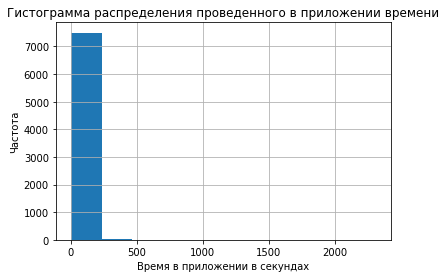

In [15]:
df_by_user = df.groupby('user_id')['event_time'].count()
df_by_user = df_by_user.reset_index()
df_by_user['event_time'].hist()
plt.xlabel('Время в приложении в секундах')
plt.ylabel('Частота')
plt.title('Гистограмма распределения проведенного в приложении времени');

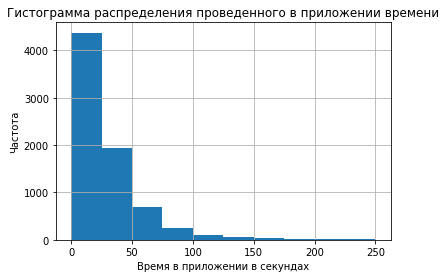

In [16]:
df_by_user['event_time'].hist(range = (0,250))
plt.xlabel('Время в приложении в секундах')
plt.ylabel('Частота')
plt.title('Гистограмма распределения проведенного в приложении времени');

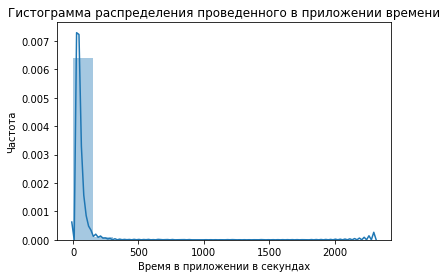

In [17]:
sns.distplot(df_by_user['event_time'], bins = 15)
plt.xlabel('Время в приложении в секундах')
plt.ylabel('Частота')
plt.title('Гистограмма распределения проведенного в приложении времени');

Ограничим время на графике по оси Х до 150 секунд

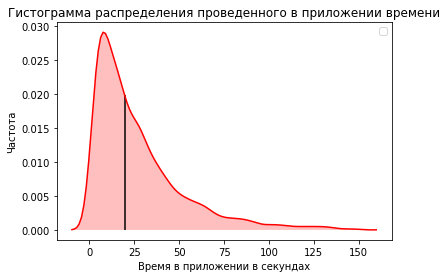

In [18]:
p=sns.kdeplot(df_by_user['event_time'], shade=True, clip=(0, 150), color='r')
x,y = p.get_lines()[0].get_data()
cdf = scipy.integrate.cumtrapz(y, x, initial=0)
nearest_05 = np.abs(cdf-0.5).argmin()
x_median = x[nearest_05]
y_median = y[nearest_05]
plt.vlines(x_median, 0, y_median)
plt.xlabel('Время в приложении в секундах')
plt.ylabel('Частота')
plt.title('Гистограмма распределения проведенного в приложении времени')
plt.legend('');

In [19]:
display('Среднее количество событий на пользователя: {:.1f}'.format(df_by_user['event_time'].mean()))

'Среднее количество событий на пользователя: 32.3'

In [20]:
display('Медианное количество событий на пользователя: {:.1f}'.format(df_by_user['event_time'].median()))

'Медианное количество событий на пользователя: 20.0'

Уточним временные рамки по данным, которые имеются

In [21]:
df['event_day'].min()

Timestamp('2019-07-25 00:00:00')

In [22]:
df['event_day'].max()

Timestamp('2019-08-07 00:00:00')

Мы располагаем данными за период от 25 июля до 7 августа 2019 года

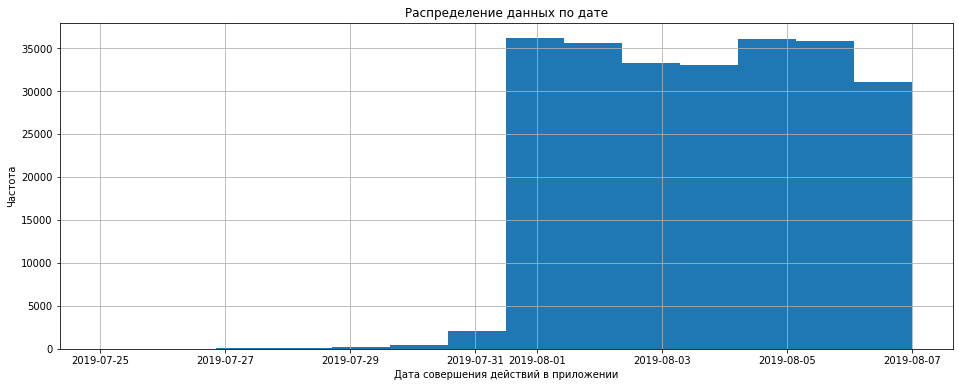

In [23]:
df['event_day'].hist(bins=14, figsize=(16,6))
plt.title('Распределение данных по дате')
plt.xlabel('Дата совершения действий в приложении')
plt.ylabel('Частота');

Большинство данных были получены начиная с 1 августа, но повышение статистики начинается с 31 июля. Возможно, за июль были получены неполные данные, либо ближе к концу июля была куплена реклама, что спровоцировало резкий скачок популярности приложения.

In [24]:
df.query('event_day < "2019-08-01"')

,event_name,user_id,event_timestamp,exp_id,event_time,event_day
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
2823,OffersScreenAppear,2413191300976302222,1564617295,247,2019-07-31 23:54:55,2019-07-31
2824,MainScreenAppear,5505110279185484837,1564617450,247,2019-07-31 23:57:30,2019-07-31
2825,MainScreenAppear,5505110279185484837,1564617462,247,2019-07-31 23:57:42,2019-07-31
2826,MainScreenAppear,5505110279185484837,1564617472,247,2019-07-31 23:57:52,2019-07-31


In [25]:
len(df.query('event_day < "2019-08-01"'))/len(df) * 100

1.159560630741897

Если отбросить данные до 1 августа, то мы потеряем 2826 события, что для датафрейма в 244126 строк незначительно и составляет около 1.16%

In [26]:
df.groupby('event_day')['user_id'].nunique()

event_day
2019-07-25       7
2019-07-26      22
2019-07-27      39
2019-07-28      69
2019-07-29     135
2019-07-30     296
2019-07-31     924
2019-08-01    3703
2019-08-02    3647
2019-08-03    3482
2019-08-04    3527
2019-08-05    3802
2019-08-06    3922
2019-08-07    3651
Name: user_id, dtype: int64

In [27]:
#df.query('event_day < "2019-08-01"').groupby('event_day')['user_id'].nunique().sum()/ df.groupby('event_day')['user_id'].nunique().sum()*100

In [28]:
df.query('event_day >= "2019-08-01"')['user_id'].nunique()/ df['user_id'].nunique()*100

99.77486425638989

In [29]:
df.query('event_day < "2019-08-01"')['user_id'].nunique()/ df['user_id'].nunique()*100

19.215997881075353

In [30]:
#df.query('event_time < "2019-08-01 00:00:00"').groupby('event_day')['user_id'].nunique()

In [31]:
df['user_id'].nunique()

7551

In [32]:
df.query('event_day >= "2019-08-01"')['user_id'].nunique()

7534

In [33]:
df.query('event_day < "2019-08-01"')['user_id'].nunique()

1451

In [34]:
datax = df.query('event_day < "2019-08-01"')
datax['user_id'].value_counts()

1076256040994094004    39
3807928414254040303    32
5505110279185484837    29
3732189810952196067    22
5224056977998049474    22
                       ..
789235048114585398      1
3978977709753461804     1
1535501606752467083     1
7244344893422246761     1
5148222703557502114     1
Name: user_id, Length: 1451, dtype: int64

Одновременно с этим "потеряем" 2% уникальных пользователей (412 человек).

In [36]:
df.head()

,event_name,user_id,event_timestamp,exp_id,event_time,event_day
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [37]:
print("Всего в логе: {} событий".format(len(df)))
print('Уникальных пользователей:  {}'.format(df['user_id'].nunique()))

Всего в логе: 243713 событий
Уникальных пользователей:  7551


In [38]:
filtered_data = df.query('event_time >= "2019-08-01"')
print("Всего в логе после фильтрации: {} событий".format(len(filtered_data)))

delta = len(df) - len(filtered_data)
percent_delta = (len(df) - len(filtered_data)) / len(df)
print("Всего отброшено событий: {}, что составляет {:.2%}".format(delta, percent_delta))

delta_users = len(df['user_id'].unique()) - len(filtered_data['user_id'].unique())
percent_delta_users = (len(df['user_id'].unique()) - len(filtered_data['user_id'].unique())) / len(df['user_id'].unique())
print("Всего отброшено пользователей: {}, что составляет {:.2%}".format(delta_users, percent_delta_users))


Всего в логе после фильтрации: 240887 событий
Всего отброшено событий: 2826, что составляет 1.16%
Всего отброшено пользователей: 17, что составляет 0.23%


In [40]:
df = df.query('event_day >= "2019-08-01"')

In [41]:
df['exp_id'].unique()

array([246, 247, 248])

Отбросив данные до 1 августа, в данных сохранились события для всех трёх экспериментальных групп

**Вывод по шагу 3:**  
Для дальнейшего анализа оставили данные, полученные за первую неделю августа.

## Изучение воронки событий

In [42]:
df['event_name'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

У нас имеются 5 событий: прохождение обучения, появление основного экрана приложения, экран с предложениями для покупки, оплата и подтверждение успешного платежа. Отсортируем их по частоте.

In [43]:
df.pivot_table(index='event_name', values='user_id', aggfunc = 'count').sort_values(by='user_id',ascending=False)

,user_id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


Мы получили отсортированные данные по названию события. Однако, не все они совершались уникальными пользователями

In [44]:
event_by_unique_user = df.pivot_table(index = 'event_name', values ='user_id', aggfunc ={'user_id':'nunique'})
#event_by_unique_user = event_by_unique_user.reset_index()
event_by_unique_user = event_by_unique_user.sort_values(by='user_id', ascending=False)
event_by_unique_user

,user_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


Уточним доли пользователей, совершавших каждое из действий. Для начала проверим общее количество уникальных пользователей, оставшихся после отсечения данных за июль

In [45]:
display('Уникальных пользователей:  {}'.format(df['user_id'].nunique()))

'Уникальных пользователей:  7534'

In [46]:
event_by_unique_user['share'] = event_by_unique_user['user_id']/df['user_id'].nunique()
event_by_unique_user.style.format({'share': "{:.2%}"})
#event_by_unique_user #.sort_values(by='user_id', ascending=False)

,user_id,share
event_name,,
MainScreenAppear,7419,98.47%
OffersScreenAppear,4593,60.96%
CartScreenAppear,3734,49.56%
PaymentScreenSuccessful,3539,46.97%
Tutorial,840,11.15%


Предположительно, обучение в приложении можно пропустить, поэтому его проходили только 11% пользователей. Соответственно, воронка, без обучения выглядит следующим образом: попадание на основной экран -> поиск товаров -> внесение информации для осуществления платежа -> подтвержение успешности платежа

In [47]:
first_step = event_by_unique_user.loc['MainScreenAppear']['user_id']/df['user_id'].nunique()
print('Уникальных пользователей:  {:.2%}'.format(first_step))

Уникальных пользователей:  98.47%


98,5% скачавших приложение перешли к основному экрану, значит 1,5% остановились на обучении.

In [48]:
second_step = event_by_unique_user.loc['OffersScreenAppear']['user_id']/event_by_unique_user.loc['MainScreenAppear']['user_id']
print('Уникальных пользователей:  {:.2%}'.format(second_step))

Уникальных пользователей:  61.91%


Пользователи попадают на основной экран приложения, но лишь 62% переходят далее к выбору товара

In [49]:
third_step = event_by_unique_user.loc['CartScreenAppear']['user_id']/event_by_unique_user.loc['OffersScreenAppear']['user_id']
print('Уникальных пользователей:  {:.2%}'.format(third_step))

Уникальных пользователей:  81.30%


Около 81% пользователей, начинающих выбирать товар, переходят к покупке, что является высоким показателем

In [50]:
fourth_step = event_by_unique_user.loc['PaymentScreenSuccessful']['user_id']/event_by_unique_user.loc['CartScreenAppear']['user_id']
print('Уникальных пользователей:  {:.2%}'.format(fourth_step))

Уникальных пользователей:  94.78%


Начиная оплату, почти 95% завершают её успешно. Выходит, что большинство пользователей теряется на втором шаге, не переходя к выбору товара.

In [51]:
funnel = event_by_unique_user.loc['PaymentScreenSuccessful']['user_id']/df['user_id'].nunique()*100
funnel

46.973719139899124

47% пользователей проходят через всю воронку и покупают товары

**Вывод по шагу 4:**  
Самая большая потеря пользователей происходит на этапе между их заходом в приложение на основной экран и выбором товаров. 

## Результаты эксперимента

Определим число пользователей в каждой экспериментальной группе

In [52]:
df.pivot_table(index='exp_id', values='user_id', aggfunc = {'user_id':'nunique'}).sort_values(by='user_id',ascending=False)

,user_id
exp_id,
248,2537
247,2513
246,2484


Создадим выборки по группам, где аа - общая контрольная группа

In [53]:
a1 = df.query('exp_id == 246')
a2 = df.query('exp_id == 247')
aa = df.query('exp_id in (246,247)')
b = df.query('exp_id == 248')

Посчитаем число пользователей, совершивших определенное действие в приложении, в каждой из контрольных групп

In [54]:
a1_pivot = a1.pivot_table(index='event_name', values = 'user_id', aggfunc = {'user_id':'nunique'})
a1_pivot

,user_id
event_name,
CartScreenAppear,1266
MainScreenAppear,2450
OffersScreenAppear,1542
PaymentScreenSuccessful,1200
Tutorial,278


In [55]:
a2_pivot = a2.pivot_table(index='event_name', values = 'user_id', aggfunc = {'user_id':'nunique'})
a2_pivot

,user_id
event_name,
CartScreenAppear,1238
MainScreenAppear,2476
OffersScreenAppear,1520
PaymentScreenSuccessful,1158
Tutorial,283


In [56]:
aa_pivot = aa.pivot_table(index='event_name', values = 'user_id', aggfunc = {'user_id':'nunique'})

Проверим гипотезу: статистически значимых различий в между группами А1 и А2 нет. Соответственно, альтернативной гипотезой будет наличие существенных различий между группами.

In [57]:
alpha = 0.05 # ваш код

results = st.mannwhitneyu(a1_pivot, a2_pivot) # ваш код

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.5
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


Контрольные группы не имеют существенных различий

Самым популярным событием является попадание пользователей на главный экран приложения. Ранее в сводных таблицах было установлено, что в группе А1 таких пользователей 2454, в группе А2 - 2482. Установим доли.

In [58]:
a1_pivot.query('event_name == "MainScreenAppear"')/(a1_pivot.sum())

,user_id
event_name,
MainScreenAppear,0.363717


Около 36% от общего числа действий в группе 1 отсносятся к переходу на главный экран

In [59]:
a2_pivot.query('event_name == "MainScreenAppear"')/(a2_pivot.sum())

,user_id
event_name,
MainScreenAppear,0.370936


В группе А2 таковых 37%.

In [60]:
b_pivot = b.pivot_table(index='event_name', values = 'user_id', aggfunc = {'user_id':'nunique'})
b_pivot

,user_id
event_name,
CartScreenAppear,1230
MainScreenAppear,2493
OffersScreenAppear,1531
PaymentScreenSuccessful,1181
Tutorial,279


В группе В 2499 пользователей перешли на основной экран.

In [61]:
b_pivot.query('event_name == "MainScreenAppear"')/(b_pivot.sum())

,user_id
event_name,
MainScreenAppear,0.371314


Их доля -  37%

In [62]:
mapping = {246:'A1',247:'A2',248:'B'}
df['AB_groups'] = df['exp_id'].map(mapping)
df.sample(10)

,event_name,user_id,event_timestamp,exp_id,event_time,event_day,AB_groups
68219,CartScreenAppear,3987249516670813491,1564767697,247,2019-08-02 17:41:37,2019-08-02,A2
54809,PaymentScreenSuccessful,3511569580412335882,1564746322,246,2019-08-02 11:45:22,2019-08-02,A1
161216,MainScreenAppear,6277910164965428737,1565014450,247,2019-08-05 14:14:10,2019-08-05,A2
158608,MainScreenAppear,4019459067081772785,1565010704,246,2019-08-05 13:11:44,2019-08-05,A1
29264,OffersScreenAppear,7145873207474249003,1564677043,247,2019-08-01 16:30:43,2019-08-01,A2
219501,MainScreenAppear,2602446729480083492,1565165056,248,2019-08-07 08:04:16,2019-08-07,B
3197,MainScreenAppear,3105205798399788133,1564624221,248,2019-08-01 01:50:21,2019-08-01,B
149791,OffersScreenAppear,1090182846018955678,1564996516,248,2019-08-05 09:15:16,2019-08-05,B
116346,MainScreenAppear,3440674572307027304,1564910576,248,2019-08-04 09:22:56,2019-08-04,B
106493,MainScreenAppear,674541835027541643,1564862727,248,2019-08-03 20:05:27,2019-08-03,B


In [63]:
tests = df.pivot_table(index='AB_groups', columns='event_name', values='user_id',  
                    aggfunc={'user_id':'nunique'}, margins=True, margins_name='total_trials')
tests=tests.reset_index()
tests

event_name,AB_groups,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,total_trials
0,A1,1266,2450,1542,1200,278,2484
1,A2,1238,2476,1520,1158,283,2513
2,B,1230,2493,1531,1181,279,2537
3,total_trials,3734,7419,4593,3539,840,7534


In [64]:
tests.loc[3] = tests.loc[0:1].sum()
tests = tests.replace('A1A2','AA')
tests

event_name,AB_groups,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,total_trials
0,A1,1266,2450,1542,1200,278,2484
1,A2,1238,2476,1520,1158,283,2513
2,B,1230,2493,1531,1181,279,2537
3,AA,2504,4926,3062,2358,561,4997


In [65]:
tests.index

RangeIndex(start=0, stop=4, step=1)

In [66]:
def test(x,y,event):
    successes = np.array([tests[tests['AB_groups']==x][event], tests[tests['AB_groups']==y][event]])
    trials = np.array([tests[tests['AB_groups']==x]['total_trials'], tests[tests['AB_groups']==y]['total_trials']])
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    alpha = .05/20
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
       print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')


Пусть нулевой гипотезой будет отстутствие различий между группами А1 и А2 по действию "переход на главный экран". Тогда альтернативная гипотеза заключается в наличии значимых различий.

In [67]:
test('A1','A2','MainScreenAppear')

p-значение:  [0.75705972]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Группы А1 и А2 не имеют существенных различий по действию "переход на основной экран". Проверим аналогичные гипотезы, сравнив контрольные группы с экспериментальной

In [68]:
test('A1','B','MainScreenAppear')

p-значение:  [0.29497219]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [69]:
test('B','A2','MainScreenAppear')

p-значение:  [0.45870536]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [70]:
test('AA','B','MainScreenAppear')

p-значение:  [0.29424527]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результатом теста является отсутствие существенных различий между долями групп А1 - В, А2 - В, АА - В, значит разбитие на эти две группы, судя по этому событию, корректно

Проверим так же нулевые гипотезы о равенстве долей (и альтернативные гипотезы о различиях) для других действий пользователей. Выходит, что для каждого из событий будет 4 сравнения:
1. А1 и А2
2. А1 и В
3. А2 и В
4. Общая группа А и В  
Начнем с "заполнения данных о карте для платежа"

In [71]:
test('A1','A2','CartScreenAppear')

p-значение:  [0.22883372]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [72]:
test('A1','B','CartScreenAppear')

p-значение:  [0.07842923]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [73]:
test('B','A2','CartScreenAppear')

p-значение:  [0.57861979]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [74]:
test('AA','A2','CartScreenAppear')

p-значение:  [0.48888735]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Во всех четырех случаях нулевая гипотеза подтверждается

Проверим на "переходе к экрану предложений"

In [75]:
test('A1','A2','OffersScreenAppear')

p-значение:  [0.24809546]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [76]:
test('A1','B','OffersScreenAppear')

p-значение:  [0.20836205]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [77]:
test('B','A2','OffersScreenAppear')

p-значение:  [0.91978178]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [78]:
test('AA','B','OffersScreenAppear')

p-значение:  [0.4342555]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


При сравнении по показателю "переход на экран предложений магазина" нулевая гипотеза так же не отвергается

In [79]:
test('A1','A2','PaymentScreenSuccessful')

p-значение:  [0.11456679]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [80]:
test('A1','B','PaymentScreenSuccessful')

p-значение:  [0.21225533]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [81]:
test('B','A2','PaymentScreenSuccessful')

p-значение:  [0.73734151]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [82]:
test('AA','B','PaymentScreenSuccessful')

p-значение:  [0.60042943]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Нет оснований считать доли для "экранов успешного платежа" разными во всех случаях

In [83]:
test('A1','A2','Tutorial')

p-значение:  [0.93769962]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [84]:
test('A1','B','Tutorial')

p-значение:  [0.8264294]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [85]:
test('A2','B','Tutorial')

p-значение:  [0.76532392]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [86]:
test('AA','B','Tutorial')

p-значение:  [0.76486247]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравнивая контрольные группы между собой, а также контрольные группы с экспрериментальной, можно прийти к выводу, что по доле пользователей, проходящих обучение, значимых различий нет.

**Вывод по шагу 5**  
Было проведено 20 тестов гипотез с уровнем значимости 0,0025 (скорректирован на поправку Бонферрони), значит ложным мог оказаться примерно 1 результат из всех. При этом сравнивая контрольные группы между собой, а также контрольные группы с экспериментальной, доли не отличались во всех случаях, что сигнализирует о корректности разделения на группы. 


## Общий вывод по исследованию

Разделение на группы проведено корректно, что позволяет использовать А/B тест для выводов об успешности эксперимента. Составим сводную таблицу по действиям и группам

In [88]:
data = df.pivot_table(index = 'event_name', columns ='AB_groups', values ='user_id', aggfunc ={'user_id':'nunique'})
data

AB_groups,A1,A2,B
event_name,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


Составим тепловую карту

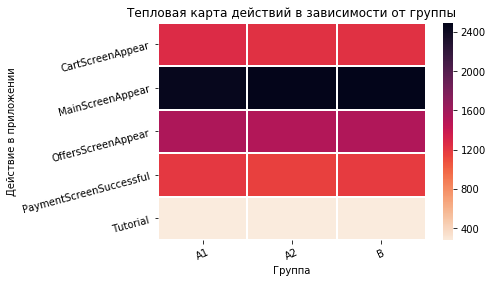

In [89]:
heatmap = sns.heatmap(data,cmap='rocket_r',linecolor='white',linewidths=1)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=15)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=25)
plt.xlabel('Группа')
plt.ylabel('Действие в приложении')
plt.title('Тепловая карта действий в зависимости от группы');

Тепловая карта показывает, что эксперимент с изменением шрифта не принёс значимых различий в количестве пользователей, совершивших действия в приложении.